# A simple background elimination method for Raman spectra

In this notebook we are trying to reproduce the background elimination technique described in the article of Seong-Joon Baek, Aaron Park, Jinyoung Kim, Aigou Shen, Jiming Hu: https://doi.org/10.1016/j.chemolab.2009.04.007 with a few variations.

### Settings and functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from bkg_elimination import bkg_elimination
%matplotlib inline
font = {'size': 15}

In [3]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]",fontsize=18)
    plt.ylabel("Intensity [some unit]",fontsize=18)

In [4]:
def define_names(r=11,c=11):
    """
    Funzione che definisce i nomi delle coordinate degli spettri sul sample. I nomi sono del tipo r1c1,r1c2, ecc.
    Come default usa 11 colonne e 11 righe. Il primo nome è wn, che sta per wave number.
    """
    #definisco i nomi da assegnare ai punti delli spettri di sampling
    #wn -> wave number  r -> row c -> columns
    names = ['wn']+[f'r{k}c{i}' for k in range(1,r+1) for i in range(1,c+1)]
    return names

In [5]:
def moving_average_filter1(a,L):
    """
    A simple (non causal) moving average filter with span L with particular boundary conditions.
    """
    if L%2==0:
        print('Error, L must be eaven')
    else:
        a=np.convolve(np.array(a),np.ones(L))
        a=np.delete(a,list(range(len(a)-(L-1)//2, len(a))))
        a=np.delete(a,list(range((L-1)//2)))
        for i in range(len(a)):
            if (L//2+1+i)<L:
                a[i]=a[i]/(L//2+1+i)
            elif L//2+(len(a)-i)<L:
                a[i]=a[i]/(L//2+(len(a)-i))
            else:
                a[i]=a[i]/L
    return a

In [6]:
def moving_average_filter(a,L):
    """
    A simple (non causal) moving average filter with span L with particular boundary conditions.
    """
    if L%2==0:
        print('Error, L must be eaven')
    else:
        a=np.convolve(np.array(a),np.ones(L))
        a=np.delete(a,np.concatenate((np.arange(1,L-1,2),np.arange(len(a)-2,len(a)-L,-2))))

        for i in range(len(a)):
            if (L//2+1+i)<L:
                a[i]=a[i]/(2*i+1)
            elif L//2+(len(a)-i)<L:
                a[i]=a[i]/((len(a)-i-1)*2+1)
            else:
                a[i]=a[i]/L
    return a

## Import of some test spectra
Here we import a few spectra on which to test this background-elimination technique. Then we chose one among these in the variable *col* on which the procedure is performed, change that variable to change the test-spectrum. At the end the chosen spectrum is plotted.

In [7]:
#definisco i nomi delle colonne da dare 
names=define_names()

#quì importiamo i dati dei sampling in dataframes pandas, la colonna dei numeri d'onda è una unica per tutti
data = pd.read_csv('./data/S1_mapA_11x11.txt', delim_whitespace=True, names=names)
data_bkg = pd.read_csv('./data/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

# The procedure

In [8]:
def interpol(S):
    min = int(S[0][0]) if S[0][0]==0 else int(S[0][0]) +1
    max = int(S[0][-1])
    X = np.arange(min,max+1,1)
    S = np.array([X, np.interp(X,S[0],S[1])])
    return S

Text(0.5, 1.0, 'Spectrum on which to test the analysis')

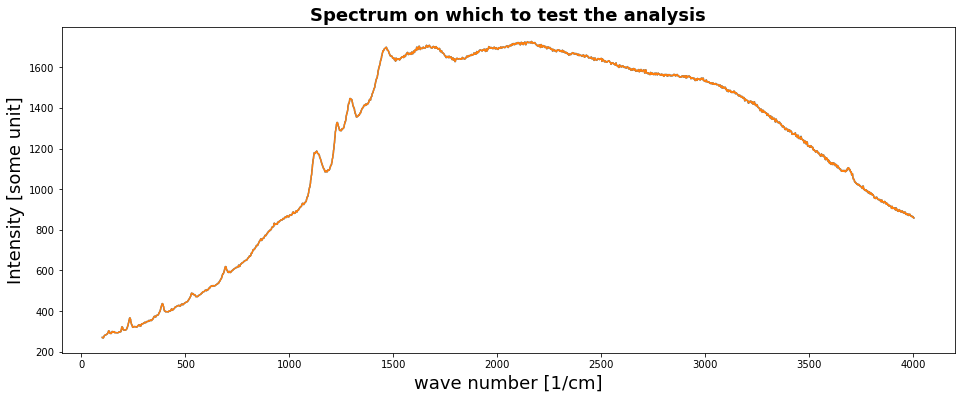

In [9]:
col='r10c6'
signal =np.array(data[['wn',col]].copy()).transpose()
raman_plot()
plt.plot(signal[0],signal[1])
signal=interpol(signal)
plt.plot(signal[0],signal[1])
plt.title('Spectrum on which to test the analysis',fontsize=18,fontweight='bold')

## Noise removal
Apply Savitzky–Golay ﬁlter with span $L_n$ to the given spectrum. The degree of a polynomial is set to 2. In the following, $s$ denotes the noise removed data. It doesn't matter if the peaks are distorted since we re interested in the background.

In [62]:
#############################################################################################
L_n=21                                       #lenght of smoothing filter for noise removal  #
L_b=201                          #lenght of smoothing filter "derivative of peaks removement#   
min_dist=1
zero=1#%                       # the zero for the derivative expressed as a % of the maximum
#############################################################################################

In [63]:
pol_degre=2
s=savgol_filter(signal[1],L_n,pol_degre)

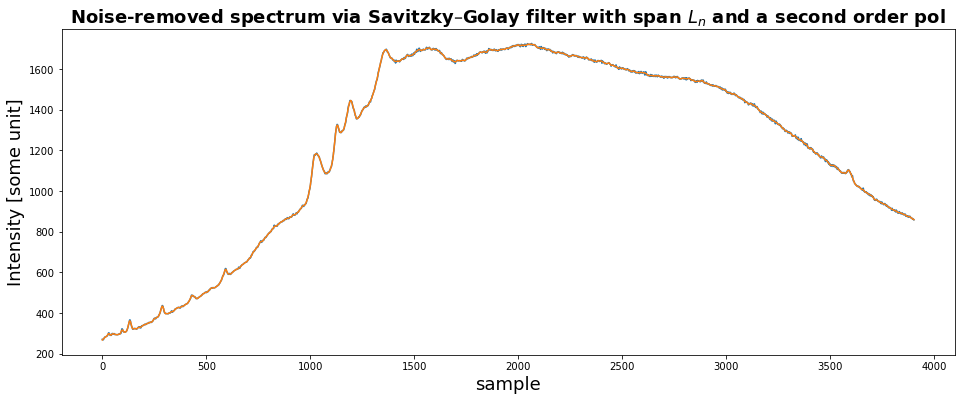

In [64]:
plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)
plt.title('Noise-removed spectrum via Savitzky–Golay filter with span $L_n$ and a second order pol',fontsize=18,fontweight='bold')
plt.plot(signal[1])
plt.plot(s)
#plt.plot(savgol_filter(s,L_n,pol_degre))

## Finding derivatives
As the noise removed data still suffer from the remaining noise, we apply smoothing to s with span $L_n$ before and after differentiation to make the derivative smoother.
$$ds=smooth(diff(smooth(s,L_n)),L_n)$$

Now the derivative of the background signal can be obtained by smoothing $ds$ three times with span $L_b$.

$$s3ds=smooth(smooth(smooth(ds,L_b),L_b),L_b)$$

Then the derivative of a given spectrum without background is simply estimated as $dg = ds − s3ds$.

In [65]:
ds=savgol_filter(np.diff(savgol_filter(s,L_n,pol_degre)),L_n,pol_degre) #the difference is a vector with one dimension less!!!

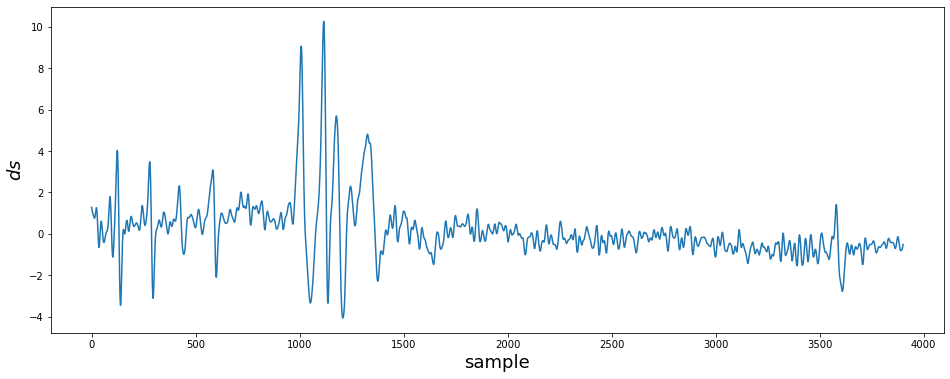

In [66]:
plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("$ds$",fontsize=18)
plt.plot(ds)

Now the derivative of the background signal can be obtained by smoothing ds three times with span $L_b$.

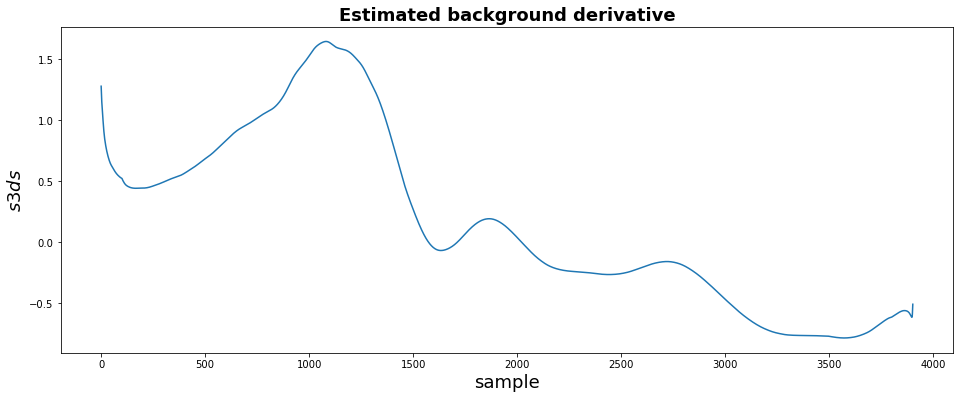

In [67]:
s3ds=moving_average_filter(moving_average_filter(moving_average_filter(ds,L_b),L_b),L_b)

plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("$s3ds$",fontsize=18)
plt.title('Estimated background derivative',fontsize=18,fontweight='bold')

plt.plot(s3ds)

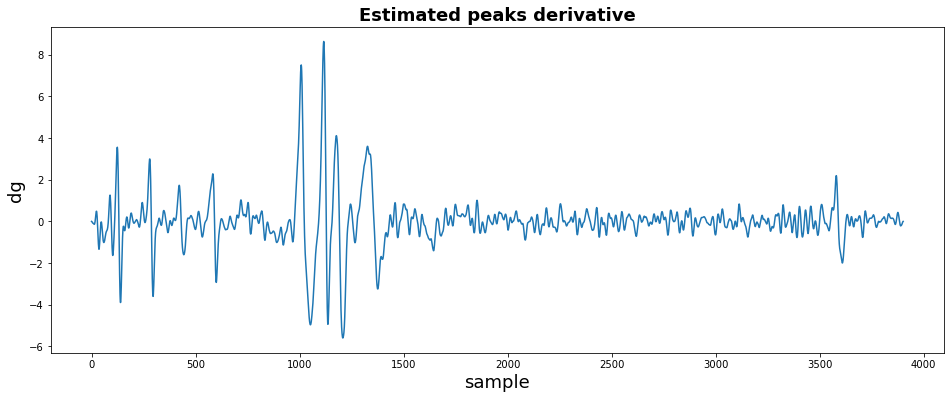

In [68]:
dg=ds-s3ds
plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("dg",fontsize=18)
plt.title('Estimated peaks derivative',fontsize=18,fontweight='bold')
plt.plot(dg)

## Peaks detection
Find peak positions ﬁrst where the sign of dg changes from + to −. Let the peak position be $p_k$, $k = 1,2,⋯,m$, where $m$ is the number of peaks found. For a given $p_k$, left and right boundary can be found in the following way. Let $i$ decrease from $p_k$. Find the position where $dg(i − 1)< dg(i)$ for local maximum. From there, proceed to ﬁnd the position where $dg(i − 1)> dg(i)$ or $dg(i − 1)< threshold$. The position $i − 1$ is left boundary, $pl_k$ . Similarly for the right boundary. The threshold is set to 0.02 in the paper. Lastly we drop small peaks, with boundary closer than $2*L_n$, and we join close peaks (i.e with close boundaries) with a parameter $min\_ dist$.

### Find peak positions

In [69]:
temp=[]
for i in range(1,len(dg)-1):
    if (dg[i-1]>0 and dg[i+1]<0) and dg[i-1]>dg[i] and dg[i]>dg[i+1]:
        temp.append(i)
peak=[]
for i in range(1,len(temp)):
    if temp[i]-temp[i-1]==1:
        peak.append(temp[i-1]) 

### Find peak boundaries

In [70]:
threshold=max(dg)*zero/100
pl=[]
pr=[]
for k in peak:
    left_m=False
    right_m=False
    for i in range(k,k-len(s),-1):
        if (left_m==True and (abs(dg[i])<threshold)) or i==0:
            pl.append(i)
            break
        if dg[i]<dg[i+1] and left_m==False:
            left_m=True
    for i in range(k,k+len(s),+1):
        if (right_m==True and (abs(dg[i])<threshold)) or i==(len(dg)-1):
            pr.append(i)
            break
        if dg[i]>dg[i-1] and right_m==False:
            right_m=True
            

### Drop small peaks

In [71]:
L_max=L_n #because L_n is of the order of half of the smallest peak, we could drop everithing smaller

temp=[]
for i in enumerate(np.array(pr)-np.array(pl)):
    if i[1]<L_max:
        temp.append(i[0])

peak=np.delete(np.array(peak),temp)
pl=np.delete(np.array(pl),temp)
pr=np.delete(np.array(pr),temp)

### Join close boundaries

In [72]:
min_dist=min_dist
for i in range(len(peak)-1):
    if pl[i+1]-pr[i]<min_dist:
        pr[i]=pr[i+1]
        pl[i+1]=pl[i]

Text(0.5, 1.0, 'Estimated peaks derivative with detected peaks')

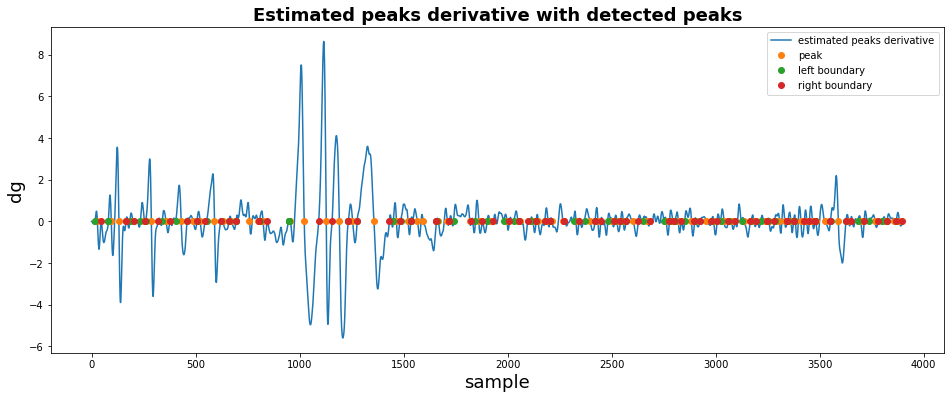

In [73]:
plt.figure(figsize=(16,6))
plt.plot(dg)
plt.plot(peak,np.zeros(len(peak)),marker='o',linewidth=0)
plt.plot(pl,np.zeros(len(peak)),marker='o',linewidth=0)
plt.plot(pr,np.zeros(len(peak)),marker='o',linewidth=0)
plt.legend(['estimated peaks derivative','peak','left boundary','right boundary'])
plt.xlabel("sample",fontsize=18)
plt.ylabel("dg",fontsize=18)
plt.title('Estimated peaks derivative with detected peaks',fontsize=18,fontweight='bold')

## Interpolation
Interpolate every peak regions of s with a straight line. Let $lints_k$ be the linearly interpolated line and $s3ds_k$ be the parts of $s3ds$ in one peak region. Interpolated samples on that region, $bkg_k$, are obtained in
the following way.

$$diffline=s3ds_k-mean(srds_k)$$
$$bkg_k=lints_k+cumsum(diffline)$$
Now background estimate, bkg, can be obtained by aggregating
interpolated samples of all peak regions together with untouched
parts of s. Then smoothed background, sbkg, is obtained as $sbkg = smooth(bkg, L_b )$.

In [74]:
bkg=s.copy()
for i in range(len(peak)):
    diffline=s3ds[pl[i]:pr[i]]-s3ds[pl[i]:pr[i]].mean()
    m=(s[pl[i]]-s[pr[i]])/(pl[i]-pr[i])
    q=(s[pr[i]]*pl[i]-s[pl[i]]*pr[i])/(pl[i]-pr[i])
    bkg[pl[i]:pr[i]]=m*np.array(range(pl[i],pr[i]))+q+np.cumsum(diffline)
sbkg=moving_average_filter(bkg,L_b)

Text(0, 0.5, 'Intensity [some unit]')

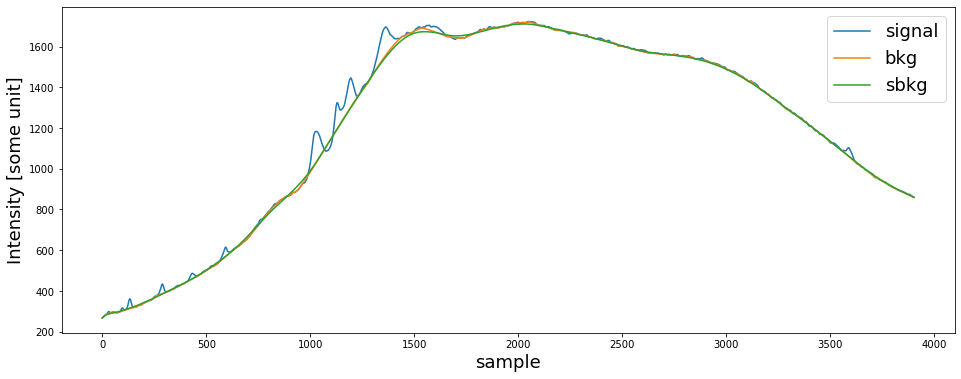

In [75]:
plt.figure(figsize=(16,6))
plt.plot(s)
plt.plot(bkg)
plt.plot(sbkg)
#plt.plot(np.cumsum(s3ds)+150)
plt.legend(['signal','bkg','sbkg','cumulative sum of s3ds+const'],fontsize=18)
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)


# Background elimination
The spectrum without background can be estimated with simple subtraction as $x = s − b$. 

In case x contains some negative values, ﬁx it by adding a constant or forcing them to zero. In our experiments, a
constant adding method is adopted.

In [76]:
x= signal- np.array([np.zeros(len(sbkg)), sbkg])

Text(0.5, 1.0, 'The background removed spectrum')

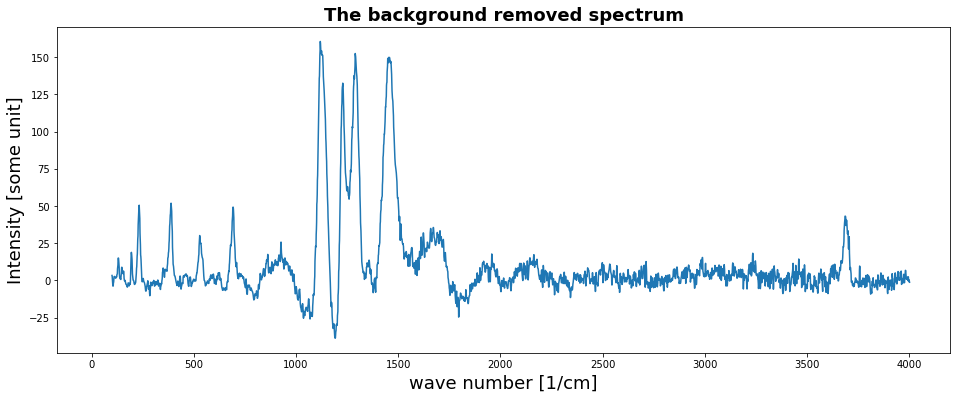

In [77]:
raman_plot()
plt.plot(x[0],x[1],31,5)

plt.title('The background removed spectrum',fontsize=18,fontweight='bold')

In [60]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter


def bkg_subtraction(S, noise_window, background_window, threshold=0.05, min_dist=1):

    L_n = int(noise_window/(S[0,0]-S[0,1]))
    L_b = int(background_window/(S[0,0]-S[0,1]))
    threshold=threshold
    min_dist=min_dist

    def _moving_average_filter(a):
        # the moving average filter with particular boundary conditions
        L=L_b
        if L%2==0:
            print('Error, L must be eaven')
        else:
            a=np.convolve(np.array(a),np.ones(L))
            a=np.delete(a,np.concatenate((np.arange(1,L-1,2),np.arange(len(a)-2,len(a)-L,-2))))

            for i in range(len(a)):
                if (L//2+1+i)<L:
                    a[i]=a[i]/(2*i+1)
                elif L//2+(len(a)-i)<L:
                    a[i]=a[i]/((len(a)-i-1)*2+1)
                else:
                    a[i]=a[i]/L
        return a


    #Filtro il segnale con un filtro di SG per rimuovere il rumore ad alta frequenza
    s = savgol_filter(S[1], L_n, 2)

    #Calcolo la derivata del segnale e la liscio, questo perchè altrimenti non riesco a lavorarci
    ds = savgol_filter( np.diff( savgol_filter( s, L_n, 2)), L_n, 2) #the difference is a vector with one dimension less!!!

    #La derivata del background è poi calcolabile filtrando con una media mobile utilizzando una finestra larga rispetto alla larghezza dei picchi
    s3ds = _moving_average_filter(_moving_average_filter(_moving_average_filter(ds)))

    #Così posso trovare la derivata del segnale di cui sono interessato
    dg=ds-s3ds

    #Trovo i centri dei picchi
    temp=[]
    for i in range(1,len(dg)-1):
        if (dg[i-1]>0 and dg[i+1]<0) and dg[i-1]>dg[i] and dg[i]>dg[i+1]:
            temp.append(i)
    peak=[]
    for i in range(1,len(temp)):
        if temp[i]-temp[i-1]==1:
            peak.append(temp[i-1]) 

    #Poi i boundary
    zero = max(dg) * threshold
    pl=[]
    pr=[]
    for k in peak:
        left_m=False
        right_m=False
        for i in range(k,k-len(s),-1):
            if (left_m==True and (abs(dg[i])<zero)) or i==0:
                pl.append(i)
                break
            if dg[i]<dg[i+1] and left_m==False:
                left_m=True
        for i in range(k,k+len(s),+1):
            if (right_m==True and (abs(dg[i])<zero)) or i==(len(dg)-1):
                pr.append(i)
                break
            if dg[i]>dg[i-1] and right_m==False:
                right_m=True

    #drop small peaks
    L_max = L_n #because L_n is of the order of half of the smallest peak, we could drop everithing smaller

    temp=[]
    for i in enumerate(np.array(pr)-np.array(pl)):
        if i[1]<L_max:
            temp.append(i[0])

    peak=np.delete(np.array(peak),temp)
    pl=np.delete(np.array(pl),temp)
    pr=np.delete(np.array(pr),temp)

    #Unisco i close boundary
    for i in range(len(peak)-1):
        if pl[i+1]-pr[i]<min_dist:
            pr[i]=pr[i+1]
            pl[i+1]=pl[i]

    #E infine interpolo il segnale s
    bkg=s.copy()
    for i in range(len(peak)):
        diffline=s3ds[pl[i]:pr[i]]-s3ds[pl[i]:pr[i]].mean()
        m=(s[pl[i]]-s[pr[i]])/(pl[i]-pr[i])
        q=(s[pr[i]]*pl[i]-s[pl[i]]*pr[i])/(pl[i]-pr[i])
        bkg[pl[i]:pr[i]]=m*np.array(range(pl[i],pr[i]))+q+np.cumsum(diffline)
            
    bkg = _moving_average_filter(bkg)

    S_nobkg = S - np.array([np.zeros(len(bkg)), bkg])
    BKG = np.array([S[0], bkg])

    return S_nobkg, BKG




In [61]:
a,b = bkg_subtraction(signal, 21,121)
plt.plot(a[0], a[1])


ValueError: polyorder must be less than window_length.